# **Imports**

In [0]:
import random as rand
import math
import csv

from matplotlib import pyplot as plt

# **Auxiliary functions and definitions**

In [0]:
#Functions

def shuffle(s):
  iterations = len(s)
  for i in range(iterations):
    index1 = rand.randint(0, len(s)-1)
    index2 = rand.randint(0, len(s)-1)
    aux = s[index1]
    s[index1] = s[index2]
    s[index2] = aux
  
def kfoldindexes(s, k):
  n = len(s)
  q = n//k
  ret = []
  for i in range(k):
    ret.append((i+1)*q - 1)
  return ret

#Definitions
activation_function_step = lambda x : -1 if x < 0 else 1
derivative_step = lambda x : 1

activation_sigmoid = lambda x : math.tanh(0.5*x)
derivative_sigmoid = lambda x : 0.5*(1 - math.tanh(0.5*x)**2)

# **Perceptron class definition**

In [0]:
class Perceptron:
  def __init__(self, weights, activation_function, learning_rate, derivative):
    self.weights = weights
    self.activation_function = activation_function
    self.learning_rate = learning_rate
    self.derivative = derivative

  def predict(self, x):
    ret = 0.0
    for i, w in enumerate(self.weights):
      ret += w*x[i]
    return self.activation_function(ret), ret

  def point_error(self, datapoint):
    return self.predict(datapoint[0])[0] - datapoint[1]

  def error(self, dataset):
    accum_error = 0
    for i in range(len(dataset)):
      accum_error += (self.point_error(dataset[i]))**2
    return accum_error*0.5

  def get_delta_weights(self, datapoint, predicted_value, excitation):
    ret = datapoint[0].copy()
    for i in range(len(ret)):
      ret[i] = self.learning_rate*(datapoint[1] - predicted_value)*datapoint[0][i]*self.derivative(excitation)
    return ret

  def update_weights(self, delta_weights):
    for i in range(len(self.weights)):
      self.weights[i] = self.weights[i] + delta_weights[i]
    return

  def train(self, dataset, max_iterations):
    error = 1
    min_error = error
    w_min = weights
    i = 0
    n = max_iterations
    errors = []
    if(max_iterations == -1):
      n = 1
    while error != 0 and i < n:
      next_datapoint = rand.choice(dataset)
      predicted_value, excitation = self.predict(next_datapoint[0])
      delta_weights = self.get_delta_weights(next_datapoint, predicted_value, excitation)
      self.update_weights(delta_weights)
      error = self.error(dataset)
      if error < min_error:
        min_error = error
        w_min = self.weights.copy()
      if(max_iterations != -1):
        i += 1
      errors.append(error)
    self.weights = w_min
    return errors

# **Multilayered perceptron class definition**

In [0]:
class MultilayeredPerceptron:
  def __init__(self, layer_amounts, amount_of_nodes, activation, learning_rate, derivative):
    self.learning_rate = learning_rate

    self.layers = [[] for i in range(layer_amounts - 1)]
    for i in range(1, layer_amounts):
      weights = [rand.uniform(0.000001, 0.05) for j in range(amount_of_nodes[i - 1] + 1)]
      self.layers[i - 1].extend([Perceptron(weights.copy(), activation[i - 1][j], learning_rate, derivative[i - 1][j]) for j in range(amount_of_nodes[i])])

  def predict(self, data):
    input_ = data.copy()
    output = 0
    for layer in self.layers:
      #print(input_)
      output = [p.predict(input_)[0] for p in layer]
      output.append(1)
      input_ = output
    return output
  
  def get_error(self, dataset):
    error = 0.0
    for datapoint in dataset:
      error += (self.predict(datapoint[0])[0] - datapoint[1])**2
    return error*0.5

  def get_deltas(self, datapoint):
    #Get all activations and excitations
    activations = []
    excitations = []
    input_ = datapoint[0]
    for layer in self.layers:
      next_activations = []
      next_excitations = []
      for p in layer:
        activation, excitation = p.predict(input_)
        next_activations.append(activation)
        next_excitations.append(excitation)
      next_activations.append(1)
      activations.append(next_activations)
      #next_excitations.append(1)
      excitations.append(next_excitations)
      input_ = activations[-1].copy()

    #Get all delta's
    deltas = [[0 for i in range(len(layer))] for layer in self.layers]
    
    #Last layer delta's
    for i in range(len(deltas[-1])):
      deltas[-1][i] = self.layers[-1][i].derivative(excitations[-1][i])*(datapoint[1] - activations[-1][i])

    #Backpropagation
    for layer in range(len(deltas) - 2, -1, -1):
      for i in range(len(deltas[layer])):
        delta = 0
        for j in range(len(deltas[layer + 1])):
          delta += deltas[layer + 1][j]*self.layers[layer + 1][j].weights[i]
        delta *= self.layers[layer][i].derivative(excitations[layer][i])
        deltas[layer][i] = delta
    
    return deltas, activations

  def train_incremental(self, dataset, max_iterations):
    error = self.get_error(dataset)
    iteration = 0
    best_weights = []
    while(iteration < max_iterations):
      datapoint = rand.choice(dataset)
      deltas, activations = self.get_deltas(datapoint)

      #Update weights for first non-input layer
      prev_weights = [[[p.weights[i] for i in range(len(p.weights))] for p in layer] for layer in self.layers]

      for j in range(len(self.layers[0])):
        new_weights = []
        for k in range(len(self.layers[0][j].weights) - 1):
          #Update non-bias weights
          new_weights.append(self.layers[0][j].weights[k] + self.learning_rate*deltas[0][j]*datapoint[0][k])
        #Update bias weight
        new_weights.append(self.layers[0][j].weights[-1] + self.learning_rate*deltas[0][j])
        self.layers[0][j].weights = new_weights
      
      #Update weights for rest of layers
      for i in range(1, len(self.layers)):
        for j in range(len(self.layers[i])):
          new_weights = []
          for k in range(len(self.layers[i][j].weights) - 1):
            #Update non-bias weights
            new_weights.append(self.layers[i][j].weights[k] + self.learning_rate*deltas[i][j]*activations[i-1][k])
          #Update bias weight
          new_weights.append(self.layers[i][j].weights[-1] + self.learning_rate*deltas[i][j])
          self.layers[i][j].weights = new_weights

      new_error = self.get_error(dataset)
      if(error > new_error):
        error = new_error
        best_weights = [[[p.weights[i] for i in range(len(p.weights))] for p in layer] for layer in self.layers]
      else:
        best_weights = prev_weights

      iteration += 1
    
    if(len(best_weights) != 0):
      for i, layer in enumerate(self.layers):
        for j, p in enumerate(layer):
          p.weights = best_weights[i][j]

    return error

In [5]:
#Class test
layer_amounts = 3
#1-dimensional input, 3 nodes in hidden layer, 1 output node
amount_of_nodes = [1, 2, 1]
learning_rate = 0.5

activations = [[activation_sigmoid for i in range(j)] for j in amount_of_nodes[1:]]
derivatives = [[derivative_sigmoid for i in range(j)] for j in amount_of_nodes[1:]]

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)

dataset = [([3, 1], 0.5), ([2, 1], 0.7), ([4, 1], -0.7)]

#deltas, activations = mlp.get_deltas(dataset[0])

print(mlp.get_error(dataset))
mlp.train_incremental(dataset, 10000)
print(mlp.predict(dataset[0][0])[0])
print(mlp.predict(dataset[1][0])[0])
print(mlp.predict(dataset[2][0])[0])
print(mlp.get_error(dataset))

0.6110124918499722
0.49644125648691334
0.7089472826725552
-0.6970417308630762
5.073493945051009e-05


# **Ejercicio 1**

Ejercicio 1: McCulloch-Pitts perceptron
AND
[0.1, 0.1, -0.1]
([-1, -1, 1], -1) -1
([1, 1, 1], 1) 1
([1, -1, 1], -1) -1
([-1, 1, 1], -1) -1


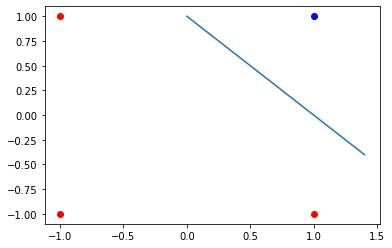

In [6]:
weights = [0 for i in range(3)]
p = Perceptron(weights, activation_function_step, 0.05, derivative_step)

#ejercicio 1, AND function
print("Ejercicio 1: McCulloch-Pitts perceptron")
print("AND")
dataset = [([-1, -1, 1], -1), ([1, 1, 1], 1), ([1, -1, 1], -1), ([-1, 1, 1], -1)]
p.train(dataset, -1)
print(p.weights)
for datapoint in dataset:
  print(str(datapoint) + ' ' + str(p.predict(datapoint[0])[0]))

#Classifying line
x = [i*0.1 for i in range(15)]
y = [a*(-1)*p.weights[0]/p.weights[1] - p.weights[2]/p.weights[1] for a in x]
plt.plot(x, y)
andx = [1, -1, -1, 1]
andy = [1, -1, 1, -1]
for i in range(len(andx)):
  if(i == 0):
    plt.scatter(andx[i], andy[i], c = 'b')
  else:
    plt.scatter(andx[i], andy[i], c = 'r')



Non linear problem cannot be solved by a single McCulloch-Pitts perceptron
[-0.1, 0.1, -0.1]
([-1, -1, 1], -1) -1
([1, 1, 1], -1) -1
([1, -1, 1], 1) -1
([-1, 1, 1], 1) 1


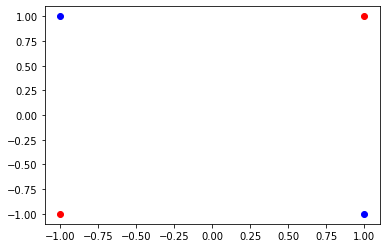

In [7]:
#ejercicio 2, XOR function
print("\nNon linear problem cannot be solved by a single McCulloch-Pitts perceptron")
xor_x = [1, -1, -1, 1]
xor_y = [1, -1, 1, -1]
for i, x in enumerate(xor_x):
  if(i <= 1):
    plt.scatter(x, xor_y[i], c = 'r')
  else:
    plt.scatter(x, xor_y[i], c = 'b')

dataset = [([-1, -1, 1], -1), ([1, 1, 1], -1), ([1, -1, 1], 1), ([-1, 1, 1], 1)]
weights = [0 for i in range(3)]
p.weights = weights
p.train(dataset, 100000)

print(p.weights)
for datapoint in dataset:
  print(str(datapoint) + ' ' + str(p.predict(datapoint[0])[0]))

# **Ejercicio 2**

**Dataset**

In [0]:
def putdatapoint(row, dataset):
  dataset.append([[float(row[0]), float(row[1]), float(row[2]), 1], float(row[3])])

def ejercicio2dataset():
  dataset = []
  with open('conjunto_de_entrenamiento_ej2.csv', newline='') as csvfile:
    r = csv.reader(csvfile)
    for row in r:
      putdatapoint(row, dataset)
  return dataset

def get_max(dataset):
  ret = dataset[0][len(dataset[0]) - 1]
  for datapoint in dataset:
    if(ret < datapoint[len(datapoint) - 1]):
      ret = datapoint[len(datapoint) - 1]
  return ret

def get_min(dataset):
  ret = dataset[0][len(dataset[0]) - 1]
  for datapoint in dataset:
    if(ret > datapoint[len(datapoint) - 1]):
      ret = datapoint[len(datapoint) - 1]
  return ret

def normalize(dataset):
  max_ = get_max(dataset)
  min_ = get_min(dataset)
  den = max_ - min_
  for i in range(len(dataset)):
    dataset[i][len(dataset[0]) - 1] = (2/90)*dataset[i][1] - 1
  print(dataset)

**K-Cross-Validation**

[[[1.2, -0.8, 0.0, 1], -0.5165555555555555], [[1.2, 0.0, -0.8, 1], -0.8405333333333334], [[1.2, -0.8, 1.0, 1], -0.0434444444444444], [[0.0, 1.2, -0.8, 1], -0.9361111111111111], [[7.9, 1.0, 0.0, 1], -0.41104444444444443], [[0.4, 0.0, 2.7, 1], 0.5237333333333334], [[0.0, 0.4, 2.7, 1], 0.3622444444444446], [[-1.3, 3.23, 3.0, 1], -0.48482222222222215], [[0.4, 2.7, 0.0, 1], -0.9373333333333334], [[0.4, 2.7, 2.0, 1], -0.607688888888889], [[-1.3, 0.0, 3.23, 1], 0.6113777777777778], [[0.0, -1.3, 3.23, 1], 0.9596444444444445], [[7.9, 1.0, -2.0, 1], -0.8966000000000001], [[1.8, 0.0, 1.6, 1], 0.08888888888888902], [[0.0, -2.0, 2.0, 1], 0.7078222222222224], [[-0.5, 0.6, 0.0, 1], -0.8250888888888889], [[0.0, 1.8, 1.6, 1], -0.5879333333333333], [[-2.0, 2.0, 0.0, 1], -0.9408888888888889], [[-0.5, 0.6, 2.5, 1], 0.1333333333333333], [[7.9, 0.0, 1.0, 1], 0.4246000000000001], [[-1.3, 3.23, 0.0, 1], -0.9671111111111111], [[0.0, 7.9, 1.0, 1], -0.9928888888888889], [[-2.0, 0.0, 2.0, 1], -0.10819999999999996

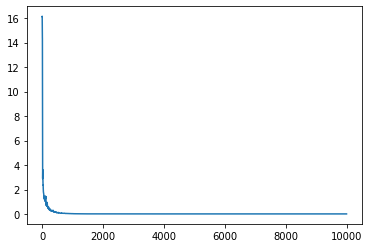

In [19]:
def kfoldcrossvalidation_perceptron(dataset, k, p):
  ret = {}
  indexes = kfoldindexes(dataset, k)
  lastindex = -1
  for i in indexes:
    #Compute training set and validation set
    validationset = dataset[lastindex + 1 : i + 1]
    trainingset = []
    if(lastindex != -1):
      trainingset.extend(dataset[0 : lastindex + 1])
    if(i != len(dataset)):
      trainingset.extend(dataset[i + 1: len(dataset) + 1])
    #Train the perceptron
    weights = [0 for i in range(len(dataset[0][0]))]
    p.weights = weights
    p.train(trainingset, 1000)
    #Compute the test error estimation and save it
    error = p.error(validationset)
    ret[i] = [error, p.weights.copy()]
    lastindex = i
  return ret

def find_min(test_error_estimates, interval_length, dataset):
  min_ = -1
  key_ret = -1
  validation = []
  training = []
  for i, key in enumerate(test_error_estimates.keys()):
    aux = test_error_estimates[key][0]
    validationset = dataset[key - interval_length + 1: key + 1]
    trainingset = dataset[0:key - interval_length + 1]
    trainingset.extend(dataset[key + 1:])
    if(min_ == -1 or min_ > aux):
      min_ = aux
      key_ret = key
      validation = validationset
      training = trainingset
  return min_, key_ret, validation, training

def evaluate_generalization_capacity(dataset):
  weights = [rand.uniform(0.000001, 0.5) for i in range(4)]
  per = Perceptron(weights, lambda x : activation_sigmoid(x), 0.0001, lambda x : derivative_sigmoid(x))
  min_ = -1
  best_k = -1
  best_index = -1
  best_v = []
  best_t = []
  for k in range(2, len(dataset)):
    if(len(dataset) % k == 0):
      test_error_estimates = kfoldcrossvalidation_perceptron(dataset, k, per)
      new_min, key, v, t = find_min(test_error_estimates, len(dataset)//k, dataset)
      if(min_ == -1 or new_min < min_):
        min_ = new_min
        best_k = k
        best_index = key
        best_v = v
        best_t = t
      weights = [rand.uniform(0.000001, 0.5) for i in range(4)]
      per.weights = weights
  return min_, best_k, best_index, best_v, best_t

dataset = ejercicio2dataset()
normalize(dataset)

per_ = Perceptron(weights, lambda x : activation_sigmoid(x), 0.1, lambda x : derivative_sigmoid(x))
weights = [rand.uniform(0.000001, 0.5) for i in range(4)]
per_.weights = weights
errors = per_.train(dataset, 10000)
plt.plot(errors)

for _ in range(10):
  min_, best_k, best_index, best_v, best_t = evaluate_generalization_capacity(dataset)
  print(best_k)
  print(min_)
  print(best_v)
  print(best_t)
  shuffle(dataset)

# **Ejercicio 3**

0.0
([1, -1, 1], 1) 1
([-1, 1, 1], 1) 1
([-1, -1, 1], -1) -1
([1, 1, 1], -1) -1
[2.5202037271620323, 0.9379181176056122, -3.0112700637370082]
[-0.5335658366065661, -1.0000954374668227, -0.9906079154278205]


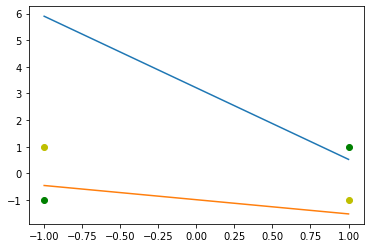

In [16]:
#XOR
layer_amounts = 3
amount_of_nodes = [2, 2, 1]
learning_rate = 0.5

activations = [[activation_function_step for i in range(j)] for j in amount_of_nodes[1:len(amount_of_nodes) - 1]]
derivatives = [[derivative_step for i in range(j)] for j in amount_of_nodes[1:len(amount_of_nodes) - 1]]
activations.append([activation_function_step])
derivatives.append([derivative_step])

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)

dataset = [([1, -1, 1], 1),([-1, 1, 1], 1),([-1, -1, 1], -1),([1, 1, 1], -1)]

mlp.train_incremental(dataset, 10000)
best_mlp = mlp
best_error = mlp.get_error(dataset)
for _ in range(10):
  mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
  mlp.train_incremental(dataset, 10000)
  error = mlp.get_error(dataset)
  if(best_error > error):
    best_mlp = mlp

print(best_mlp.get_error(dataset))
for datapoint in dataset:
  print(str(datapoint) + ' ' + str(best_mlp.predict(datapoint[0])[0]))

xor_x = [1, -1, -1, 1]
xor_y = [1, -1, 1, -1]
for i, x in enumerate(xor_x):
  if(i <= 1):
    plt.scatter(x, xor_y[i], c = 'g')
  else:
    plt.scatter(x, xor_y[i], c = 'y')

print(best_mlp.layers[0][0].weights)
print(best_mlp.layers[0][1].weights)
wl1 = best_mlp.layers[0][0].weights
wl2 = best_mlp.layers[0][1].weights
line = [0.1*i - 1 for i in range(21)]
line_y1 = [(-wl1[0]/wl1[1])*x - wl1[2]/wl1[1] for x in line]
line_y2 = [(-wl2[0]/wl2[1])*x - wl2[2]/wl2[1] for x in line]
plt.plot(line, line_y1, line, line_y2)


[1, -1, 1] -> ([-1, -1], 1)
[-1, 1, 1] -> ([-1, -1], 1)
[-1, -1, 1] -> ([-1, 1], -1)
[1, 1, 1] -> ([1, -1], -1)


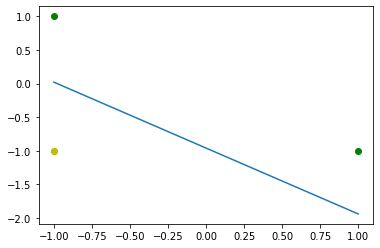

In [18]:
transformed = []
for i in range(len(dataset)):
  transformed.append(([best_mlp.layers[0][0].predict(dataset[i][0])[0], best_mlp.layers[0][1].predict(dataset[i][0])[0]], dataset[i][1]))
for i, t in enumerate(transformed):
  print(str(dataset[i][0]) + ' -> ' + str(t))
  if(t[1] == 1):
    plt.scatter(t[0][0], t[0][1], c = 'y')
  else:
    plt.scatter(t[0][0], t[0][1], c = 'g')

wl3 = best_mlp.layers[1][0].weights
line_x = [0.1*i - 1 for i in range(21)]
line_y = []
if(wl3[1] == 0):
  line_y = [-wl3[2]/wl3[0] for x in line_x]
else:
  line_y = [(-wl3[0]/wl3[1])*x - wl3[2]/wl3[1] for x in line_x]
plt.plot(line_x, line_y)

In [12]:
#Prime numbers
def ejercicio3_dataset():
  f = open('conjunto_de_entrenamiento_ej3.txt')
  ret = []
  for i in range(10):
    next_number = []
    for j in range(7):
      next_number.extend([int(x) for x in f.readline().strip().split(' ')])
      next_number.append(1)
    ret.append((next_number, -1))
  return ret

dataset = ejercicio3_dataset()

dataset[2] = (dataset[2][0], 1)
dataset[3] = (dataset[3][0], 1)
dataset[5] = (dataset[5][0], 1)
dataset[7] = (dataset[7][0], 1)

layer_amounts = 3
amount_of_nodes = [35, 1, 1]
learning_rate = 0.5

activations = [[activation_function_step for i in range(j)] for j in amount_of_nodes[1:len(amount_of_nodes) - 1]]
derivatives = [[derivative_step for i in range(j)] for j in amount_of_nodes[1:len(amount_of_nodes) - 1]]
activations.append([activation_function_step])
derivatives.append([derivative_step])

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
mlp.train_incremental(dataset, 10000)
best_mlp = mlp
best_error = mlp.get_error(dataset)
for _ in range(10):
  mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
  mlp.train_incremental(dataset, 10000)
  error = mlp.get_error(dataset)
  if(best_error > error):
    best_mlp = mlp

print(best_mlp.get_error(dataset))
for i, datapoint in enumerate(dataset):
  print(str(i) + ' ' + str(datapoint[1]) + ' ' + str(best_mlp.predict(datapoint[0])[0]))

print()
print("Sin el 7")
new_dataset = dataset[0:7]
new_dataset.extend(dataset[8:10])

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
mlp.train_incremental(new_dataset, 10000)
best_mlp = mlp
best_error = mlp.get_error(new_dataset)
for _ in range(10):
  mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
  mlp.train_incremental(new_dataset, 10000)
  error = mlp.get_error(dataset)
  if(best_error > error):
    best_mlp = mlp

print(best_mlp.get_error(dataset))
for i, datapoint in enumerate(dataset):
  print(str(i) + ' ' + str(datapoint[1]) + ' ' + str(best_mlp.predict(datapoint[0])[0]))

print()
print("Sin el 7 ni el 2")
new_dataset = dataset[0:2]
new_dataset.extend(dataset[3:7])
new_dataset.extend(dataset[8:10])

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
mlp.train_incremental(new_dataset, 10000)
best_mlp = mlp
best_error = mlp.get_error(new_dataset)
for _ in range(10):
  mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
  mlp.train_incremental(new_dataset, 10000)
  error = mlp.get_error(dataset)
  if(best_error > error):
    best_mlp = mlp

print(best_mlp.get_error(dataset))
for i, datapoint in enumerate(dataset):
  print(str(i) + ' ' + str(datapoint[1]) + ' ' + str(best_mlp.predict(datapoint[0])[0]))

print()
print("Sin el 8 ni el 0")
new_dataset = dataset[1:8]
new_dataset.extend(dataset[9:10])

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
mlp.train_incremental(new_dataset, 10000)
best_mlp = mlp
best_error = mlp.get_error(new_dataset)
for _ in range(10):
  mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
  mlp.train_incremental(new_dataset, 10000)
  error = mlp.get_error(dataset)
  if(best_error > error):
    best_mlp = mlp

print(best_mlp.get_error(dataset))
for i, datapoint in enumerate(dataset):
  print(str(i) + ' ' + str(datapoint[1]) + ' ' + str(best_mlp.predict(datapoint[0])[0]))

print()
print("Sin el 5")
new_dataset = dataset[0:5]
new_dataset.extend(dataset[6:10])

mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
mlp.train_incremental(new_dataset, 10000)
best_mlp = mlp
best_error = mlp.get_error(new_dataset)
for _ in range(10):
  mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
  mlp.train_incremental(new_dataset, 10000)
  error = mlp.get_error(dataset)
  if(best_error > error):
    best_mlp = mlp

print(best_mlp.get_error(dataset))
for i, datapoint in enumerate(dataset):
  print(str(i) + ' ' + str(datapoint[1]) + ' ' + str(best_mlp.predict(datapoint[0])[0]))

print()
print("Cambiando el primer y segundo bit más significativo")
mlp = MultilayeredPerceptron(layer_amounts, amount_of_nodes, activations, learning_rate, derivatives)
mlp.train_incremental(dataset, 10000)
#Change dataset
new_dataset = dataset.copy()
for i in range(len(new_dataset)):
  new_dataset[i][0][0] = 1 - new_dataset[i][0][0]
  new_dataset[i][0][1] = 1 - new_dataset[i][0][1]
#Evaluate new dataset
print(mlp.get_error(new_dataset))
for i, datapoint in enumerate(dataset):
  print(str(i) + ' ' + str(datapoint[1]) + ' ' + str(mlp.predict(datapoint[0])[0]))


0.0
0 -1 -1
1 -1 -1
2 1 1
3 1 1
4 -1 -1
5 1 1
6 -1 -1
7 1 1
8 -1 -1
9 -1 -1

Sin el 7
0.0
0 -1 -1
1 -1 -1
2 1 1
3 1 1
4 -1 -1
5 1 1
6 -1 -1
7 1 1
8 -1 -1
9 -1 -1

Sin el 7 ni el 2
2.0
0 -1 -1
1 -1 -1
2 1 1
3 1 1
4 -1 -1
5 1 1
6 -1 -1
7 1 -1
8 -1 -1
9 -1 -1

Sin el 8 ni el 0
2.0
0 -1 1
1 -1 -1
2 1 1
3 1 1
4 -1 -1
5 1 1
6 -1 -1
7 1 1
8 -1 -1
9 -1 -1

Sin el 5
2.0
0 -1 -1
1 -1 -1
2 1 1
3 1 1
4 -1 -1
5 1 -1
6 -1 -1
7 1 1
8 -1 -1
9 -1 -1

Cambiando el primer y segundo bit más significativo
2.0
0 -1 -1
1 -1 1
2 1 1
3 1 1
4 -1 -1
5 1 1
6 -1 -1
7 1 1
8 -1 -1
9 -1 -1
